# Signal Preprocessing and Analysis

### This notebook objective is to analyze raw signal dataset representing time-series data from urine spectrometry measurements

### Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, detrend, find_peaks

### Uploading the data

In [4]:
data = pd.read_csv('signal.csv')
data.head(10)

,Unnamed: 0,Time,Noisy_Trended_Signal
0,0,0.00000,-0.212277
1,1,0.01001,0.249596
2,2,0.02002,0.507517
3,3,0.03003,0.836112
4,4,0.04004,1.088553
5,5,0.05005,1.184766
6,6,0.06006,1.389889
7,7,0.07007,1.328603
8,8,0.08008,1.413306
9,9,0.09009,1.377757


### Data Handeling

In [14]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head(10)

,Time,Noisy_Trended_Signal
0,0.00000,-0.212277
1,0.01001,0.249596
2,0.02002,0.507517
3,0.03003,0.836112
4,0.04004,1.088553
5,0.05005,1.184766
6,0.06006,1.389889
7,0.07007,1.328603
8,0.08008,1.413306
9,0.09009,1.377757


#### Handeling NaN values

In [9]:
data.isnull().sum()

,0
Time,0
Noisy_Trended_Signal,0


There are not NaN values

#### Preprocessing

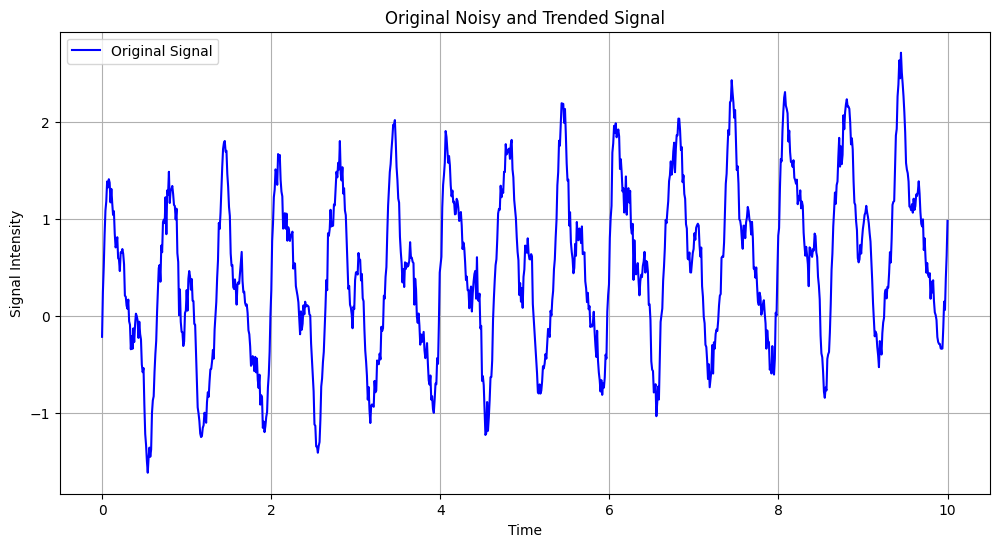

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Noisy_Trended_Signal'], label='Original Signal', color='blue')
plt.title('Original Noisy and Trended Signal')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.grid(True)
plt.legend()
plt.show()

##### Filtering

In [28]:
def low_pass_filter(signal, cutoff_frequency, sampling_rate, order=4):
    """
    Apply a low-pass filter to a signal.
    Parameters:
    - signal: The input signal to be filtered.
    - cutoff_frequency: The cutoff frequency for the filter.
    - sampling_rate: The sampling rate of the signal.
    - order: The order of the Butterworth filter.
    """
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

* sampling rate of a signal is the ratio between the number of samples and the total time in seconds

Sampling Rate: 100.0 Hz


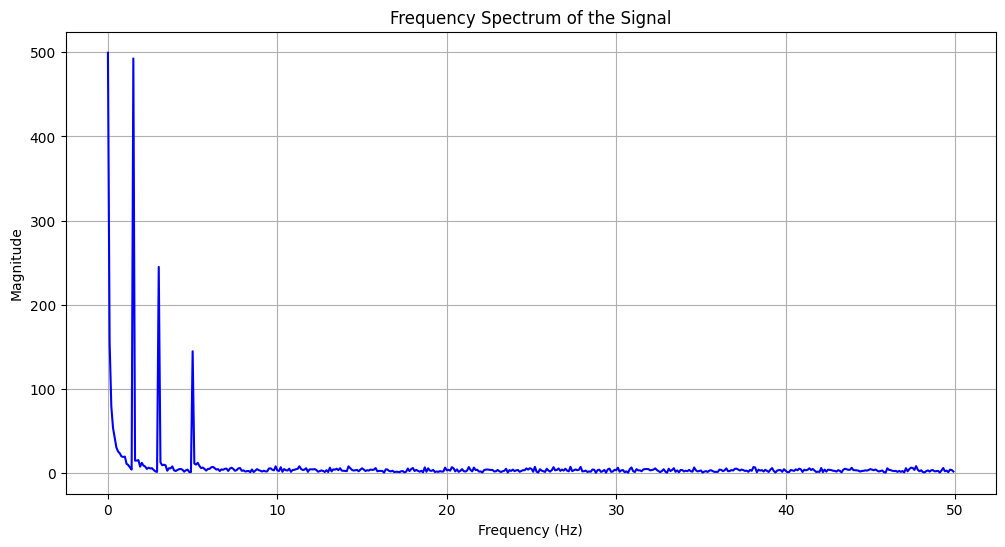

Suggested Cutoff Frequency: 7.5 Hz


In [34]:
n = len(data['Noisy_Trended_Signal'])
sampling_rate = data.shape[0] / 10 # number of samples / time in seconds
print(f"Sampling Rate: {sampling_rate} Hz")

fft_values = np.fft.fft(data['Noisy_Trended_Signal'])
fft_frequencies = np.fft.fftfreq(n, d=1/sampling_rate)

# Only take the positive half of the spectrum
positive_freqs = fft_frequencies[:n//2]
positive_magnitude = np.abs(fft_values[:n//2])

plt.figure(figsize=(12, 6))
plt.plot(positive_freqs, positive_magnitude, color='blue')
plt.title('Frequency Spectrum of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude)*0.1)

if len(peaks) > 0:
    max_peak_freq = positive_freqs[peaks].max()

    cutoff_frequency = max_peak_freq * 1.5
else: # default if no peaks were found
    cutoff_frequency = 1.0

print(f"Suggested Cutoff Frequency: {cutoff_frequency} Hz")